In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def convolution(image, kernel):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))

    print("Kernel Shape : {}".format(kernel.shape))

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image


    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image size : {}".format(output.shape))

    plt.imshow(output, cmap='gray')
    plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
    plt.show()

    return output

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math

def dnorm(x, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], sigma)
        print(i,kernel_1D[i])
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    plt.imshow(kernel_2D, interpolation='none', cmap='gray')
    plt.title("Kernel ( {}X{} )".format(size, size))
    plt.show()

    return kernel_2D


def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size))
    return convolution(image, kernel)

0 0.05399096651318806
1 0.24197072451914337
2 0.3989422804014327
3 0.24197072451914337
4 0.05399096651318806


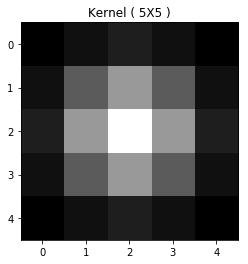

[[0.01831564 0.082085   0.13533528 0.082085   0.01831564]
 [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
 [0.13533528 0.60653066 1.         0.60653066 0.13533528]
 [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
 [0.01831564 0.082085   0.13533528 0.082085   0.01831564]]


In [10]:
print(gaussian_kernel(5))

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def sobel_edge_detection(image, filter):
    new_image_x = convolution(image, filter)

    plt.imshow(new_image_x, cmap='gray')
    plt.title("Horizontal Edge")
    plt.show()

    new_image_y = convolution(image, np.flip(filter.T, axis=0))

    plt.imshow(new_image_y, cmap='gray')
    plt.title("Vertical Edge")
    plt.show()

    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

    gradient_magnitude *= 255.0 / gradient_magnitude.max()

    plt.imshow(gradient_magnitude, cmap='gray')
    plt.title("Gradient Magnitude")
    plt.show()

    gradient_direction = np.arctan2(new_image_y, new_image_x)

    gradient_direction = np.rad2deg(gradient_direction)
    gradient_direction += 180

    return gradient_magnitude, gradient_direction

0 0.05467002489199788
1 0.0806569081730478
2 0.10648266850745075
3 0.12579440923099774
4 0.1329807601338109
5 0.12579440923099774
6 0.10648266850745075
7 0.0806569081730478
8 0.05467002489199788


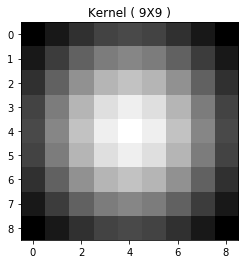

Converted to Gray Channel. Size : (186, 271)
Kernel Shape : (9, 9)
Output Image size : (186, 271)


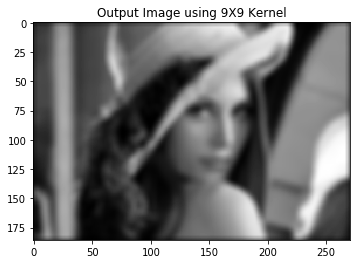

Image Shape : (186, 271)
Kernel Shape : (3, 3)
Output Image size : (186, 271)


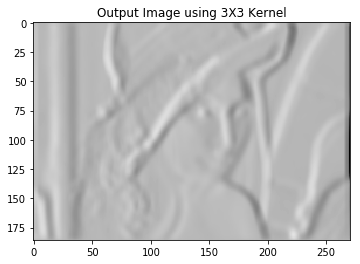

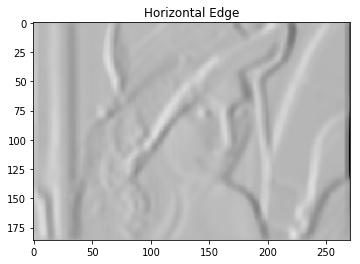

Image Shape : (186, 271)
Kernel Shape : (3, 3)
Output Image size : (186, 271)


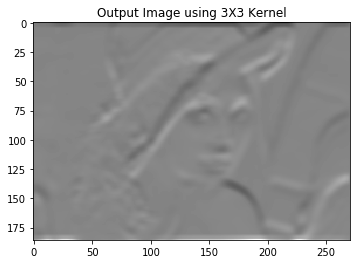

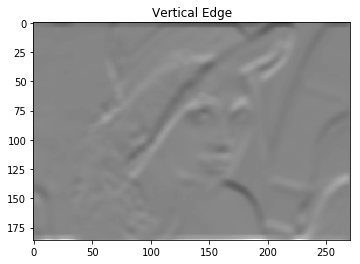

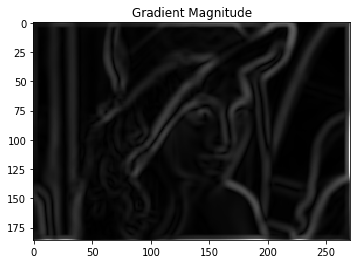

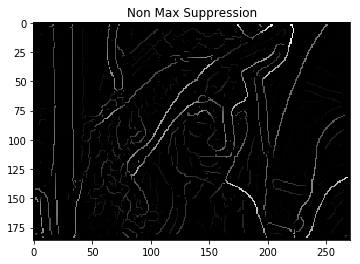

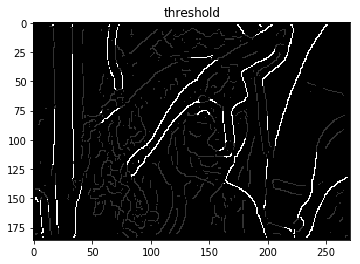

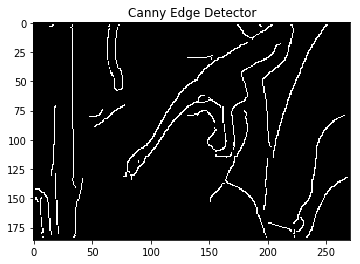

In [32]:
import numpy as np
import cv2
import argparse

import matplotlib.pyplot as plt


def non_max_suppression(gradient_magnitude, gradient_direction):
    image_row, image_col = gradient_magnitude.shape

    output = np.zeros(gradient_magnitude.shape)

    PI = 180

    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]

            # (0 - PI/8 and 15PI/8 - 2PI)
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]

            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]

            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]

            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]

            if gradient_magnitude[row, col] >= before_pixel and gradient_magnitude[row, col] >= after_pixel:
                output[row, col] = gradient_magnitude[row, col]

    plt.imshow(output, cmap='gray')
    plt.title("Non Max Suppression")
    plt.show()

    return output


def threshold(image, low, high, weak):
    output = np.zeros(image.shape)

    strong = 255

    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    
    plt.imshow(output, cmap='gray')
    plt.title("threshold")
    plt.show()

    return output


def hysteresis(image, weak):
    image_row, image_col = image.shape

    top_to_bottom = image.copy()

    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right

    final_image[final_image > 255] = 255

    return final_image

if __name__ == '__main__':
    #ap = argparse.ArgumentParser()
    #ap.add_argument("-i", "--image", required=True, help="Path to the image")
    #args = vars(ap.parse_args())
    args = "/home/ankit/lena.jpeg"
    image = cv2.imread(args)

    blurred_image = gaussian_blur(image, kernel_size=9)

    edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    gradient_magnitude, gradient_direction = sobel_edge_detection(blurred_image, edge_filter)

    new_image = non_max_suppression(gradient_magnitude, gradient_direction)

    weak = 50

    new_image = threshold(new_image, 5, 35, weak=weak)

    new_image = hysteresis(new_image, weak)

    plt.imshow(new_image, cmap='gray')
    plt.title("Canny Edge Detector")
    plt.show()